# Topic Detection with LDA (Latent Dirichlet allocation)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import operator
import collections

## Loading data
* Here we load the stopwords (their usage will be explained later) and all the data through an helper function load_data(). This function load all the data in one dictionary (all data) and two lists (condensed and master) and returns them. The dictionary values and the lists elements are pandas DataFrames. For what concerns the dictionary, we can access a DataFrame that refers to a json file using the file name without the .json extension. E.g.: all_data["condensed_2009"]

In [2]:
with open('stopwords/stopwords_joined.json', 'r') as f:
         stopwords = json.load(f)
        
all_data, condensed, master = load_data()

* We decided to use only the condensed tweets and not the master ones because in the latter ones there are a lot of informations that are not useful to our analysis. Every DataFrame in the condensed list contains all the tweets of one specific year (from 2009 to 2017).
* As explained in David Robertson's [article](http://varianceexplained.org/r/trump-tweets/) and as reproduced by us, Trump tweets from an Android phone (and in the first years from a laptop). All the tweets from an iPhone are tweets made by his staff, so we decided to exclude them from our analysis. We excluded as well the retweets, because they are not preparatory for studying Trump's behavior.
* So what we are going to do is to save every text from the tweets in a list and all the info about those tweets in another list. In this way we can work with text only elements and when we will need them, it will be easy to link the text to their additional info.

In [3]:
def to_flat_list(list_):
    '''Helper function that transforms a list of list in a flat list'''
    return [item for sublist in list_ for item in sublist]

# This list will contain the texts from every tweet chosen
condensed_text = []
# This list will contain the dates from every tweet chosen
condensed_date = []
# This list will contain the retweet counts from every tweet chosen
condensed_retweet_count = []
# This list will contain the favorite counts from every tweet chosen
condensed_favorite_count = []
# This list will contain the ids from every tweet chosen
condensed_id = []

'''
Now, for every element (DataFrame) in the condensed list, we take the informations 
above explained and we put them in the right list.
We don't choose tweets that are retweet or that are from an iPhone.
'''
for x in condensed:
    temp = x[x.is_retweet == False]
    temp = temp[temp.source != "Twitter for iPhone"]
    condensed_text.append(temp.text.tolist())
    condensed_date.append(temp.created_at.tolist())
    condensed_retweet_count.append(temp.retweet_count.tolist())
    condensed_favorite_count.append(temp.favorite_count.tolist())
    condensed_id.append(temp.id_str.tolist())

'''
Since we don't want to have a list of lists (every list inside the list now contains
the specific data (text, date, ...) for an entire year: we don't want to make a difference
between the years now), we make every list a flat list.
'''
flat_list_text = to_flat_list(condensed_text)
flat_list_date = to_flat_list(condensed_date)
flat_list_retweet_count = to_flat_list(condensed_retweet_count)
flat_list_favorite_count = to_flat_list(condensed_favorite_count)
flat_list_id = to_flat_list(condensed_id)

'''
Evert additional information (i.e. everything that is not the text of a tweet) is saved
in a list of tuples. Every tuple is composed by (date, retweet_count, favorite_count, id).
The elements on the same index of the two lists (flat_list_text and flat_list_info) refer
to the same tweet.
'''
flat_list_info = []
for date, ret, fav, id_ in zip(flat_list_date, flat_list_retweet_count, flat_list_favorite_count, flat_list_id):
    flat_list_info.append((date, ret, fav, id_))

## LDA

* From now on, we will start the process of 'clustering' the texts in different topics.
* Additional note: before using the stopwords, we tried to use stemming on the text. Stemming is the process that reduce every word to its root. This method didn't give us the expected results. If you are interested in the stemming process, we used PorterStemmer from nltk library. You can find all the documentation [here](http://www.nltk.org/api/nltk.stem.html).

* We use a CountVectorized (from skelearn) that convert a collection of text documents to a matrix of token counts. We chose a max_features = 1000 in order to take account of only the 1000 most used words in the bag of words matrix.
* The stopwords used in this script are an union between handmade stopwords and the stopwords that you can get [here](https://www.ranks.nl/stopwords) - in the section 'Long Stopword List'. Every word inside the stopwords is not used to cluster the tweets. They are really useful because without them we could find tweets in the same topic but that refer to different topics. For example, 'the' is a very common stopword, because it doesn't give any information about the topic of the tweet. If we take account of that word during the clustering, two tweets that have a lot of 'the' in their content may finish in the same topic, but it's not right!

In [4]:
no_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stopwords)

* Now we are going to call two methods from the tf_vectorizer: fit_transform and get_features_names. The first one learn the vocabulary dictionary and return the term-document matrix. Every row of the matrix refer to a term and every column refer to a document. Every value is given by: tf_i,j * idf_i.
* Let's explain them: tf_i,j is the term frequency of the i_th term on the j_th document, so tf_i,j = Nij/Dj, where Nij is the occurency of term i in document j and Dj is the length (number of words) of the document j; idf_i is the inverse document frequency and so idf_i = log10(D/number_of_documents_that_contain_i): D is the total number of documents and the denominator is self explaining. So the idf_i factor explains the importance of a term in that document. Here is an example: let's say that we have 10 documents and we take the 3rd one. In the 3rd one we choose the word 'cat', which is repeated 20 times, so tf_cat,3 = 20. We can find the word 'cat' in only 1 other document, so this means that cat is very important to describe this document, since it's very rare to find it in other documents. That's why the idf_cat will be very high: idf_cat = log10(20/2) = 1.
* get_features_names() returns an array mapping from feature integer indices to feature name, or, in other words, the 1000 words that have been chosen by the CountVectorizer.

In [5]:
tf = tf_vectorizer.fit_transform(flat_list_text)
tf_feature_names = tf_vectorizer.get_feature_names()

* Unluckily, the LDA algorithm can't find automatically the number of topics and so we need to give him the number of total topics that we have to find. Before finding the right number of topics and the right stopwords in order to have coherence in our topics, we had to try many times. The final result is that if we divide all the texts in 8 topics and then work a little bit with them, we find good coherence in the texts of the same topic.

In [6]:
no_topics = 8
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

* At this point, in order to show our results, we need to find the W (topics to documents) and H (word to topics) matrices. H: every row is a topic, every column is a word (columns length = no_features); the elements inside the matrix contain the weight of every word about the topic. W: every row is a document, every column is a topic; the elements inside the matrix contain the weight of every topic in the document.

In [7]:
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

* Here we define a function that shows the first three words and three documents and their scores of every topic. If you want to see more documents, just change the variables number_of_words and number_of_documents.

In [8]:
def show_topics(H, W, feature_names, documents, number_of_words, number_of_documents):
    '''
    If we do an inverse argsort of a topic (of a row) of matrix H, that returns the indices of the ordered list
    of the scores/weights and we use those indices to extract words from feature_names.
    These words will be ordered from the most to the least important.
    We did the same reasoning for the W matrix (documents)
    '''
    
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort(W[:, topic_idx])[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print('Score: ' + str(W[doc_index, topic_idx]))
            print('\n')
            
no_top_words = 3
no_top_documents = 3
show_topics(lda_H, lda_W, tf_feature_names, flat_list_text, no_top_words, no_top_documents)

Topic 0:
country america 2016
The  @SuperCommittee must cut spending, not raise taxes. Washington has a spending problem, not a revenue problem.
Score: 0.902777777062


The Washington Establishment will never rein in government spending, waste, fraud and abuse. A great thinker and outsider is needed.
Score: 0.890624999112


He is destroying our country:@BarackObama has requested to raise our debt limit to over $16.4Trillion by the end (cont) http://t.co/A5DGJvhP
Score: 0.890621265436


Topic 1:
vote media hotel
Those five hotels includeTrump International Hotel & Tower New York, Trump Soho New York, Trump International Hotel & Tower Chicago...
Score: 0.92045349805


...Trump International Hotel Las Vegas, and Trump International Hotel & Tower Waikiki Beach Walk. http://tlworldsbest.roiresearch.com/.
Score: 0.902777777445


Check out Trump International Hotel & Tower New York --spectacular! http://www.trump.com/Hotel_Collection/Trump_New_york/Trump_New_York.asp
Score: 0.874997860738


T

* We looked through the documents in the topics and we found out that the 8 topics are divided as follows:
     <p>0) POLITICS
     <p>1) HOTELS AND GOLF
     <p>2) POLITICS
     <p>3) CELEBRITY APPRENTICE AND SHOWS
     <p>4) BOOKS, YANKEES, QUOTATIONS
     <p>5) GOLF, TRUMP'S BUSINESS
     <p>6) QUATATIONS, COMMENTS OF DIFFERENT KIND
     <p>7) INTERVIEWS AND DEBATES

* We can see that the clustering is not perfect (category 4 and 6 are a little confused), but we are having the first results. We can see that not always there is a strong correspondance between the most common words and the real meaning of the topic, but we will take care of that.
* First we will put together topics 1-5 in a TRUMP'S BUSINESS CATEGORY: this new cluster will contain topics such as golf, hotels, Trump's cologne, Trump Signature Collection... Secondly we will put together topics 4-6 in a VARIOUS category: this new cluster will contain topics such as general tweets, books, quotations... Lastly, we will put together topics 0-2: this new topic will contain everything that refers to politics.
* While putting everything together, we will have to be careful in choosing the documents that refer to that topic with a score at least of the 60% in order to mantain coherence. For this reason we will not consider documents for a topic under that threshold.
* NOTE: we can have the same document in more topics.

In [9]:
business = []
scores_business = []
various = []
scores_various = []
politics = []
scores_politics = []
shows = []
scores_shows = []
interviews = []
scores_interviews = []

number_of_tweets_kept = 0
'''In every topic list we append the text and the index of the tweet in order to get the info later'''
for topic_idx, topic in enumerate(lda_H):

    # Taking the indices of the documents ordered by importance in the topic
    top_doc_indices_ordered = np.argsort(lda_W[:, topic_idx])[::-1]

    for doc_index in top_doc_indices_ordered:
        score = lda_W[doc_index, topic_idx]

        # If the documents are less important than 0.60, I finish collecting documents for that topic
        if (score < 0.60):
            break

        # BUSINESS
        if topic_idx == 1 or topic_idx == 5:

            business.append([flat_list_text[doc_index], doc_index])
            scores_business.append(score)

        # VARIOUS
        elif topic_idx == 4 or topic_idx == 6:

            various.append([flat_list_text[doc_index], doc_index])
            scores_various.append(score)

        # POLITICS
        elif topic_idx == 0 or topic_idx == 2:
            politics.append([flat_list_text[doc_index], doc_index])
            scores_politics.append(score)

        # CELEBRITY APPRENTICE AND SHOWS
        elif topic_idx == 3:

            shows.append([flat_list_text[doc_index], doc_index])
            scores_shows.append(score)

        # INTERVIEWS AND DEBATES
        elif topic_idx == 7:

            interviews.append([flat_list_text[doc_index], doc_index])
            scores_interviews.append(score)
        
        number_of_tweets_kept += 1

* Now let's see what happened! We will show just the first 5 documents in the topic, but if you are curious to see more do not hesitate to see more documents just changing the max_document value

In [10]:
max_document = 5
'''PRINT BUSINESS TOPIC'''
scores_business_idx_ordered = np.argsort(scores_business)[::-1][:max_document]
print("NEW TOPIC: BUSINESS")
for index in scores_business_idx_ordered:
    print(business[index])
    print(scores_business[index])
    print()

NEW TOPIC: BUSINESS
['Those five hotels includeTrump International Hotel & Tower New York, Trump Soho New York, Trump International Hotel & Tower Chicago...', 61]
0.92045349805

['...Trump International Hotel Las Vegas, and Trump International Hotel & Tower Waikiki Beach Walk. http://tlworldsbest.roiresearch.com/.', 60]
0.902777777445

['Spent a beautiful weekend golfing at Trump National Golf Club Westchester and Trump National Golf Club Bedminster.', 100]
0.902774476063

['.@mcuban says he is a member of Dallas National but doesn’t play golf. Who is a member of a golf club that doesn’t play?? No talent! @TMZ', 17281]
0.902714327093

['Check out Trump International Hotel & Tower New York --spectacular! http://www.trump.com/Hotel_Collection/Trump_New_york/Trump_New_York.asp', 96]
0.874997860738



In [11]:
'''PRINT VARIOUS TOPIC'''
scores_various_idx_ordered = np.argsort(scores_various)[::-1][:max_document]
print("NEW TOPIC: VARIOUS ")
for index in scores_various_idx_ordered:
    print(various[index])
    print(scores_various[index])
    print()

NEW TOPIC: VARIOUS 
['.@AlexSalmond –the man who let terrorist (Pan Am Flight 103) al-Megrahi  go, lost another battle over ugly wind turbines in Blackdog.', 5288]
0.874998269897

['“Deals are my art form.  I like making deals, preferably big deals.” – The Art of The Deal', 1026]
0.874997785613

["Today's open call drew thousands of  eager applicants. It was an impressive group,  I enjoyed meeting them. We've got some great candidates!", 179]
0.874997138082

['A great gift idea is my new book #TimeToGetTough, easy to order on Amazon    http://t.co/V6RmNj7x', 249]
0.874978824221

["Third Gun Linked to 'Fast and Furious' Identified at Border Agent's Murder Scene. When will the White House come clean?", 666]
0.854166665992



In [12]:
'''PRINT POLITICS TOPIC'''
scores_politcs_idx_ordered = np.argsort(scores_politics)[::-1][:max_document]
print("NEW TOPIC: POLITICS ")
for index in scores_politcs_idx_ordered:
    print(politics[index])
    print(scores_politics[index])
    print()

NEW TOPIC: POLITICS 
['The  @SuperCommittee must cut spending, not raise taxes. Washington has a spending problem, not a revenue problem.', 486]
0.902777777062

['The Keystone pipeline will create 20,000 jobs and lower gas prices. But Obama says No. Dumb.', 217]
0.902747617842

['The Washington Establishment will never rein in government spending, waste, fraud and abuse. A great thinker and outsider is needed.', 198]
0.890624999112

['He is destroying our country:@BarackObama has requested to raise our debt limit to over $16.4Trillion by the end (cont) http://t.co/A5DGJvhP', 208]
0.890621265436

["China has 5 oil projects in Iraq and we didn't get anything from the Iraqis except asked to leave. Iraq is going (cont) http://t.co/KhujI5YC", 210]
0.890616822269



In [13]:
'''PRINT SHOWS TOPIC'''
scores_shows_idx_ordered = np.argsort(scores_shows)[::-1][:max_document]
print("NEW TOPIC: SHOWS ")
for index in scores_shows_idx_ordered:
    print(shows[index])
    print(scores_shows[index])
    print()

NEW TOPIC: SHOWS 
["I appeared on David Letterman last night. And don't forget Sunday night---the first episode of Celebrity Apprentice will be on NBC at 9 pm.", 944]
0.927083329968

['ALso coming up: The Celebrity Apprentice returns. Sunday night March 6 at 9 pm EST http://www.nbc.com/the-apprentice/', 948]
0.920454543331

["Don't forget! Sunday night at 9 pm EST on @nbc--Celebrity Apprentice is back! Tune in for a great show. @ApprenticeNBC", 4188]
0.920454543234

["Sunday night at 9 PM EST will be re-run of last week's episode of Celebrity @ApprenticeNBC, followed by new episode at 10 PM.", 10078]
0.91249999745

['Only 10 more days until the premiere of All-Star @ApprenticeNBC. On March 3rd at 9PM EST @NBC the fireworks return to the Board Room!', 11315]
0.912497131447



In [14]:
'''PRINT INTERVIEWS AND DEBATES TOPIC'''
scores_interviews_idx_ordered = np.argsort(scores_interviews)[::-1][:max_document]
print("NEW TOPIC: INTERVIEWS AND DEBATES ")
for index in scores_interviews_idx_ordered:
    print(interviews[index])
    print(scores_interviews[index])
    print()

NEW TOPIC: INTERVIEWS AND DEBATES 
['A clip from my @foxandfriends interview discussing how  Newsmax-@iontv debate is determining the GOP primary polls http://t.co/yqIzaX1W', 313]
0.902770346112

['My @FoxNews interview with @megynkelly discussing the 2012 election and the Newsmax-@iontv debate http://t.co/TotTpvNZ', 319]
0.902768694732

['My interview on @theviewtv discussing #TimeToGetTough, the GOP primary and the Newsmax-@iontv  debate(starts at 23:00) http://t.co/ROcUyAXe', 312]
0.902757538492

['My FoxBusiness interview with Don Imus discussing #TimeToGetTough, the GOP primary and the Newsmax-@iontv debate http://t.co/ZafIoWf2', 318]
0.890598756259

['My interview with @EWErickson of @RedState discussing #TimeToGetTough, GOP primary and my 2012 options  http://t.co/SD6NqxZR', 290]
0.874976061873



* Since we have chosen to keep only the documents that refered to one topic with a score of 60%, we are keeping only ~14% of the total tweets in the topic detection. We think that is fine, because the analysis that refer to the topics is not influenced by other tweets.

In [15]:
len(flat_list_text), number_of_tweets_kept

(28220, 3769)

In [16]:
print('Number of tweets in topic politics: ', len(politics))
print('Number of tweets in topic business: ', len(business))
print('Number of tweets in topic various: ', len(various))
print('Number of tweets in topic shows: ', len(shows))
print('Number of tweets in topic interviews: ', len(interviews))

Number of tweets in topic politics:  1536
Number of tweets in topic business:  691
Number of tweets in topic various:  498
Number of tweets in topic shows:  743
Number of tweets in topic interviews:  301


* We can clearly see that the topic with more tweets is the politic one. But if we make a research for the words 'hillary', 'clinton', 'crooked', we can find them only in 15 tweets! Probably the Clinton topic was not recognized in our clustering, but it's not a problem. We can make a keyword research from all the topics and find the ones that talk about Hillary Clinton using an helper function get_hillary_tweets_16_17. We are going to take the tweets of the last 2 years because that is the period of the elections and presidency of Trump, when he had to face his opponent.

In [17]:
hillary_words = ['hillary', 'clinton', 'crooked']
number_of_tweets_hillary = 0
for tweet in politics:
    for word in hillary_words:
        if word in tweet[0].lower():
            number_of_tweets_hillary += 1
            break
number_of_tweets_hillary

15

In [18]:
hillary_topic, hillary_info = get_hillary_tweets_16_17(all_data)

* Since politics is a very big topic (it contains more than 1500 documents) we decided to split it in the most common Trump's topic about politics: China, Obama, foreign politics (contains also China topic), internal politics (contains also Obama topic and Hillary topic) and Trump topic. The last one refers to the candidacy, the electoral campaign and tweets of political ideas of Trump. In order to do so we will load the keywords that refer to this topics.

In [19]:
with open('keywords/china_keywords.json', 'r') as fp:
    china_keywords = json.load(fp)
    
with open('keywords/obama_keywords.json', 'r') as fp:
    obama_keywords = json.load(fp)
    
with open('keywords/hillary_keywords.json', 'r') as fp:
    hillary_keywords = json.load(fp)
    
with open('keywords/foreign_politics_keywords.json', 'r') as fp:
    foreign_politics_keywords = json.load(fp)
    
with open('keywords/internal_politics_keywords.json', 'r') as fp:
    internal_politics_keywords = json.load(fp)
    
with open('keywords/trump_keywords.json', 'r') as fp:
    trump_keywords = json.load(fp)

* In the next lines of code, we are going to detect if at least one of the keywords of the topic is inside the text of the tweet. If so we will add that tweet to his topic list and we will search for the keywords of another topic. If we found one keyword, we add the text and then break the for loop on the keywords because the topic is already been detected. If a tweet is not put in any topic, it will finish in the not_got list. The not_got list is a way to clean a little more our clusters.
* Before doing everything explained above, we are going to remove the tweets that refer to Hillary Clinton from the politcs topic. We are doing this because every topic that refer to Hillary is already in the Hillary topic and we don't want duplicates
* The commentated code is the code that we used to create the json file that we will use later.

In [20]:
# Removing the tweets in politics that contain hillary, because we are going to add every tweet that refers to hillary
# later and we don't want to have duplicates
for tweet in list(politics):
    if ('hillary' in tweet[0]) or ('clinton' in tweet[0]) or ('Hillary' in tweet[0]) or ('Clinton' in tweet[0]):
        politics.remove(tweet)


china_topic = []
obama_topic = []
foreign_politics_topic = []
internal_politics_topic = []
trump_4pre_topic = []
not_got = []

for tweet in politics:

    control = 0

    # date, ret, fav, id_ = flat_list_info[tweet[1]]
    # json_file = {
    #     'created_at': str(date),
    #     'id': id_,
    #     'retweet_count': ret,
    #     'favorite_count': fav,
    #     'text': tweet[0],
    #     'topic': ''
    # }

    for keyword in china_keywords:
        if keyword in tweet[0]:
            china_topic.append(tweet)

            # json_file['topic'] = 'china'
            # china_json.append(json_file.copy())

            control += 1
            break

    for keyword in obama_keywords:
        if keyword in tweet[0]:
            obama_topic.append(tweet)

            # json_file['topic'] = 'obama'
            # obama_json.append(json_file.copy())

            control += 1
            break

    for keyword in foreign_politics_keywords:
        if keyword in tweet[0]:
            foreign_politics_topic.append(tweet)

            # json_file['topic'] = 'foreign_politics'
            # foreign_politics_json.append(json_file.copy())

            control += 1
            break

    for keyword in internal_politics_keywords:
        if keyword in tweet[0]:
            internal_politics_topic.append(tweet)

            # json_file['topic'] = 'internal_politics'
            # internal_politics_json.append(json_file.copy())

            control += 1
            break

    for keyword in trump_keywords:
        if keyword in tweet[0]:
            trump_4pre_topic.append(tweet)

            # json_file['topic'] = 'trump_politcs'
            # trump_4pre_json.append(json_file.copy())

            control += 1
            break

    if control == 0:
        not_got.append(tweet)

In [21]:
not_got[:5]

[['WASTE--HUD is spending $70M to teach grant recipients how to spend the money from their grants http://t.co/zKgdVbCd  Does it get any dumber?',
  3467],
 ['The reason great dealmakers do not OPENLY celebrate a deal, especially one that is not complete, is that it shows weakness to the other side',
  4962],
 ['Negotiation tip #1:  The worst thing you can possibly do in a deal is seem desperate to make it.',
  1158],
 ['As usual, the "storm of the century" was not nearly as bad as forecast. What a waste of time, energy and money!',
  24542],
 ['The more time you spend feeling sorry for yourself, the more time you waste after a setback. Move on and quickly embrace the next challenge!',
  4641]]

In [22]:
len(not_got)

157

* As we can see from the 5 documents on the not_got, they don't really refer to politics. Luckily, just a little more of 150 documents where outsiders.

## Sentiment of the tweets

* We wanted to study the sentiments that these tweets contain. We started with an easy inspection.
* We downloaded the [NRC Emotion Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) kindly offered by the National Research Council Canada, created by Saif Mohammad. We used the 'NRC-Emotion-Lexicon-Wordlevel-v0.92' dataset, that contains 14.000 words. Every word is associated with 8 emotions and a positive or negative value.

### Sentiment of the tweets associated to a topic

* We searched for every word in every tweet and we summed the values of every sentiment associated.
* It takes a few time to compute every sentiment for every tweet: you can decide to run the following cell or to run the next one that load the pre-computed dataframe from a csv file.

In [50]:
'''
This is an helper function that load the 'lexicons? (word -> emotion) from a file and returns
a pandas DataFrame with a column 'term' and other 10 columns that are the emotions associated.
'''
lexicons = load_lexicons()

'''Loading files'''
dir_path = 'topic_tweets'
directory = os.fsencode(dir_path)

first = True
tweets = pd.DataFrame()
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename == '.DS_Store':
        continue
    if first:
        tweets = pd.read_json(dir_path + '/' + filename)
        first = False
    else:
        tweets = tweets.append(pd.read_json(dir_path + '/' + filename))

length = lexicons.shape[0]

# We create a column for every emotion
tweets['anger'] = 0
tweets['anticipation'] = 0
tweets['disgust'] = 0
tweets['fear'] = 0
tweets['joy'] = 0
tweets['negative'] = 0
tweets['positive'] = 0
tweets['sadness'] = 0
tweets['surprise'] = 0
tweets['trust'] = 0

for index, lexicon in lexicons.iterrows():
    # print('Iterations to the end: %s...' % (length - index))

    tweets_with_lexicon = tweets['text'].str.contains(lexicon.term, case=False)

    # We take the emotions
    emotions = lexicon.drop(['term'])

    # For every emotion we update the value in the df
    if any(tweets_with_lexicon.values):
        for attribute, value in zip(emotions.index.values, emotions.values):
            if value != 0:
                tweets.loc[tweets_with_lexicon, attribute] += value

# tweets.to_csv('data/tweets_topic_em.csv')

In [23]:
tweets_topic_em = pd.read_csv('data/tweets_topic_em.csv', index_col=0)
tweets_topic_em.set_index('id', inplace=True)

In [24]:
tweets_topic_em.head()

,created_at,favorite_count,retweet_count,text,topic,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
id,,,,,,,,,,,,,,,
14358664722776064,2010-12-13 16:39:07,6,14,Those five hotels includeTrump International H...,business,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0
14359503306752000,2010-12-13 16:42:27,6,12,"...Trump International Hotel Las Vegas, and Tr...",business,2.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0
22812888292,2010-09-02 16:37:23,10,21,Check out Trump International Hotel & Tower Ne...,business,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
301817282286460928,2013-02-13 22:17:02,72,131,"Wow, Trump International Hotel &amp; Tower Tor...",business,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
572852786657828864,2015-03-03 20:15:22,47,30,"Trump International Hotel &amp; Tower, Vancouv...",business,2.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0


In [25]:
tweets_topic_em.tail()

,created_at,favorite_count,retweet_count,text,topic,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
id,,,,,,,,,,,,,,,
585596721918513152,2015-04-08 00:15:13,64,40,"""@SportsTalkCSN: TONIGHT at 10 on CSN:@CHICKat...",various,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,1.0
176775397143347200,2012-03-05 21:05:13,20,91,"I fully support the @NYPD, @MayorBloomberg and...",various,2.0,2.0,4.0,4.0,1.0,5.0,8.0,3.0,0.0,5.0
785302681560748032,2016-10-10 02:15:24,28559,11184,"In my administration, EVERY American will be t...",various,2.0,1.0,4.0,4.0,1.0,4.0,10.0,3.0,1.0,5.0
672384440270782464,2015-12-03 11:58:37,1829,898,"""@iliveamongyou: @chucktodd APOLOGIZE HYPOCRIT...",various,0.0,2.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,3.0
329579793530109952,2013-05-01 12:55:20,76,242,Money is really cheap so this is a great time ...,various,1.0,3.0,0.0,0.0,1.0,1.0,6.0,0.0,1.0,4.0


* What we are going to do now is to group the dataframe by the topic and see the differences between the sentiments in the different topics

In [26]:
sentiment = tweets_topic_em.drop(['created_at', 'text']).groupby('topic').mean()

In [27]:
sentiment

,favorite_count,retweet_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
topic,,,,,,,,,,,,
business,765.389291,284.600579,0.848046,1.015919,0.806078,0.865412,1.014472,1.881331,3.551375,0.855282,1.153401,1.986975
china,1084.668874,483.291391,1.509934,1.072848,1.099338,1.649007,0.821192,3.278146,3.099338,1.516556,0.536424,1.768212
foreign_politics,2722.202505,1050.772443,1.530271,1.083507,1.164927,1.734864,0.789144,3.240084,3.277662,1.586639,0.611691,1.862213
hillary,29381.834884,10625.983721,2.839535,1.202326,2.476744,2.497674,0.900000,5.169767,3.513953,2.309302,0.665116,1.930233
internal_politics,12529.637263,4484.502885,1.896950,1.202803,1.618302,1.959604,0.873866,3.934872,3.609233,2.000824,0.632317,2.007420
interviews_debates,2669.996678,945.425249,0.973422,1.096346,0.823920,1.009967,0.870432,2.215947,3.594684,1.438538,0.754153,2.013289
obama,1452.431718,764.962555,1.352423,1.085903,1.072687,1.561674,0.850220,3.343612,3.266520,2.022026,0.572687,1.808370
shows,770.577389,223.056528,1.076716,1.567968,1.002692,1.006729,1.154778,1.952894,3.445491,0.815612,1.119785,2.720054
various,2761.224900,1099.192771,1.048193,1.453815,0.971888,1.291165,1.182731,2.178715,3.730924,1.206827,1.271084,2.168675


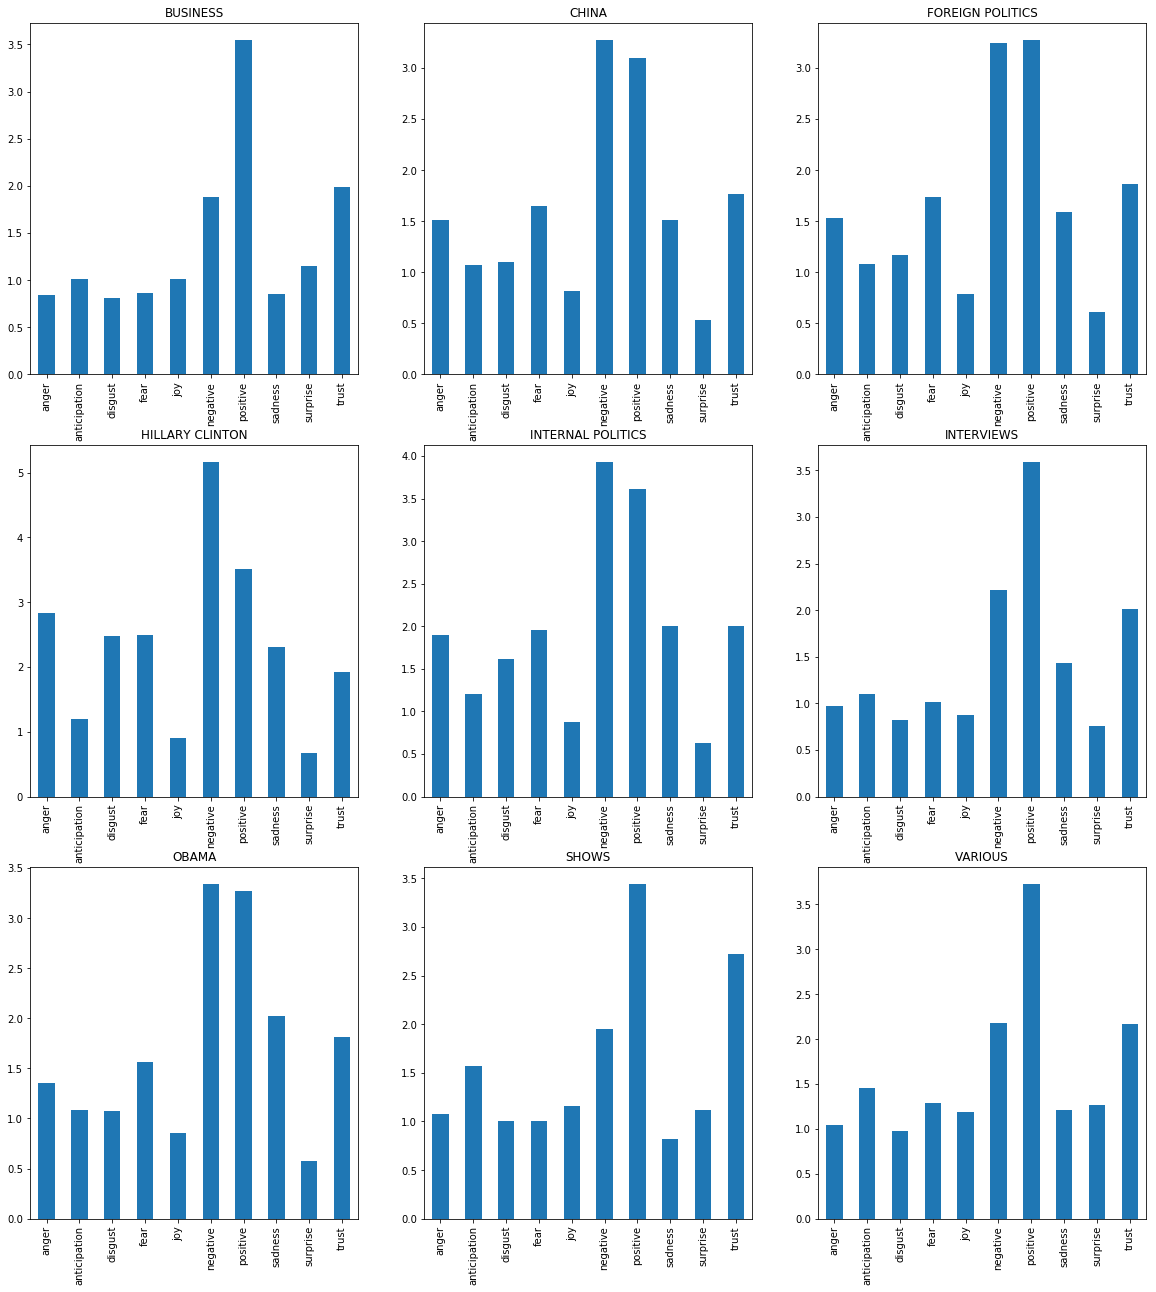

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(20,22))

sentiment.loc['business'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,0])
axs[0,0].set_title("BUSINESS")

sentiment.loc['china'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,1])
axs[0,1].set_title("CHINA")

sentiment.loc['foreign_politics'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[0,2])
axs[0,2].set_title("FOREIGN POLITICS")

sentiment.loc['hillary'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,0])
axs[1,0].set_title("HILLARY CLINTON")

sentiment.loc['internal_politics'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,1])
axs[1,1].set_title("INTERNAL POLITICS")

sentiment.loc['interviews_debates'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[1,2])
axs[1,2].set_title("INTERVIEWS")

sentiment.loc['obama'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,0])
axs[2,0].set_title("OBAMA")

sentiment.loc['shows'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,1])
axs[2,1].set_title("SHOWS")

sentiment.loc['various'].drop(['favorite_count', 'retweet_count']).plot(kind='bar', ax=axs[2,2])
axs[2,2].set_title("VARIOUS")
plt.show()

* We can see that generally Trump have more positive tweets than negative, he needs people to like him for his business and for his politics. More specifically we can find a confirm of this fact lookin at the sentiments in Business, Shows and Interviews. Of course, when he speaks about his business, he has to be positive: we can see an high level of trust in his tweets. For what concerns shows, we can say very similar things: he produces and leads a tv show called 'Celebrity Apprentice' and he often tweets about it. He needs to transmit positive vibes to convince people that his show is worth watching. A very similar pattern for similar reason is found in the interviews and debate topic.
* For what concerns politics we have different trends: there are high level of anger and fear, with an high level of trust, in every topic concerning politics except for Obama, that is a little different. When it comes to politics he generally have slightly more negative tweets than positive. The interesting thing is that his level of trust is always  highest in every topic compared to the other emotions as we expected, except when he talks about Hillary Clinton or Barack Obama.
* Clinton: the highest emotion are anger, fear, disgust and sadness in this order. Not that it's not something that we were not expecting, but the fact that the trust level is lower than four other negative emotions it's very relevant.
* Obama: here positive and negative emotions are almost at the same level, even if sadness is the highest emotion we can find. Levels of trust are second, so differently from Clinton topic, his more trustful when he speaks about Obama than Clinton.
* Note that the levels of joy are often low compared to the other emotions, except for shows and business.

* Now that we have seen Trump's emotions in his tweets, it would be curious to discover what the Twitter's users think about those tweets. In order to understand that, we are going to analyze the number of favorite and retweet counts, that is the only information we have about Trump's public.

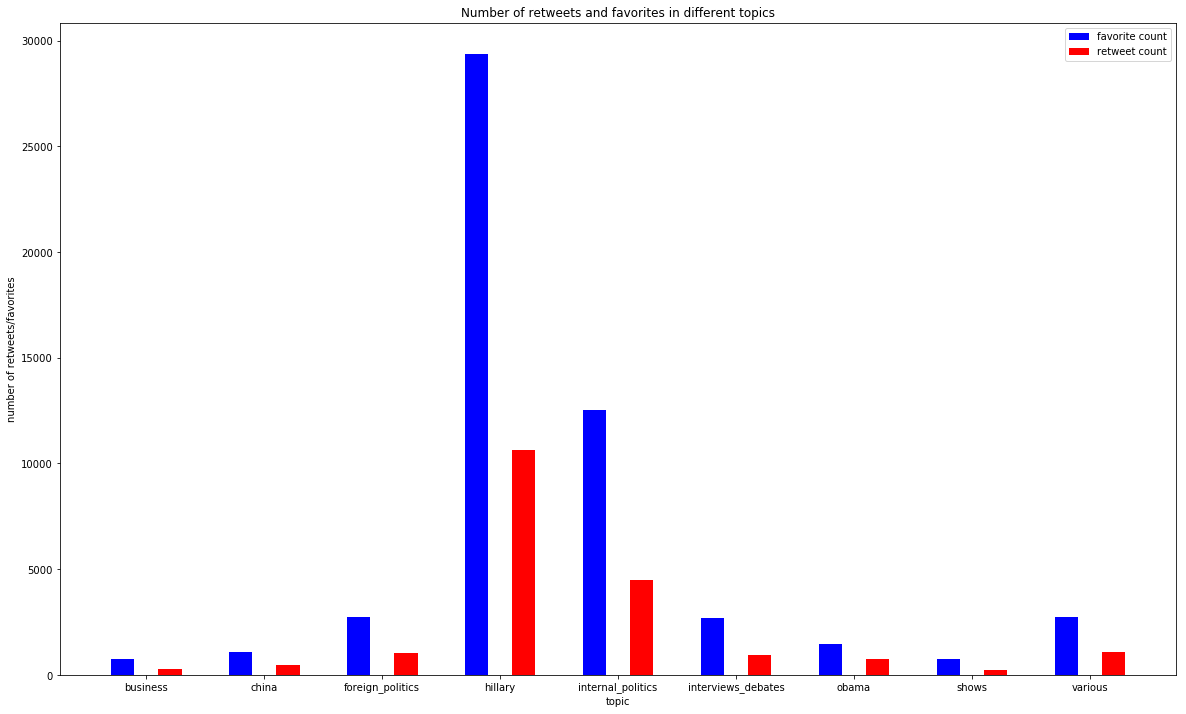

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
x = np.array([0,1,2,3,4,5,6,7,8])
ax.bar(x - 0.2, sentiment.loc[:,'favorite_count'], width=0.2, color ='b')
ax.bar(x + 0.2, sentiment.loc[:,'retweet_count'], width=0.2, color ='r')
ax.set_xticks(x)
ax.set_xticklabels(sentiment.index.values)
ax.set_xlabel('topic')
ax.set_ylabel('number of retweets/favorites')
ax.set_title("Number of retweets and favorites in different topics")
ax.legend(['favorite count', 'retweet count'])

plt.show()

* We can clearly see that the number of retweet and favorite are way higher when they are about hillary clinton. These tweets are from 2016 and 2017, so as we know, during the election campaign Trump's tweets reached a very high popularity. Also the internal politics topic has a very high range of favorite and retweet count for two main reason: first because it contains also the tweets that refer to Hillary topic and second because a lot of tweets of that topic are during the campaing as shown below.

/Users/lorenzotara/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


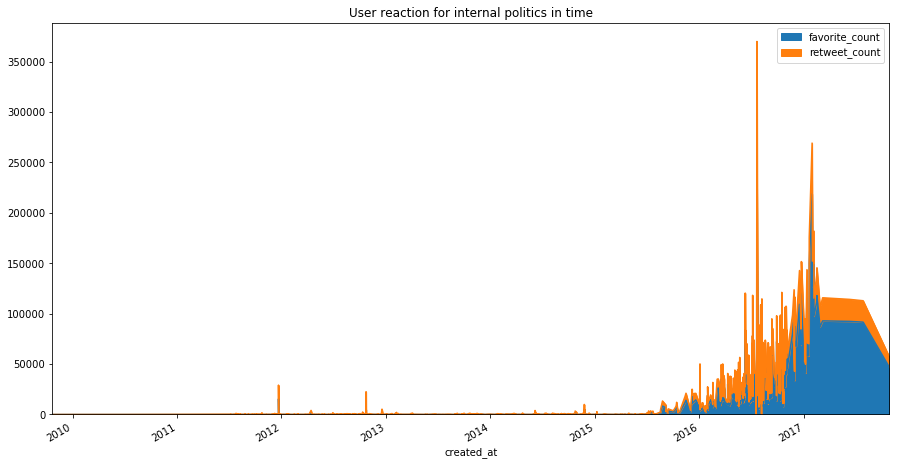

In [30]:
int_pol = tweets_topic_em[tweets_topic_em.topic == 'internal_politics']
int_pol.created_at = int_pol.created_at.apply(pd.to_datetime)
int_pol.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,8))
int_pol.plot(kind='area', x='created_at', y=['favorite_count','retweet_count'], ax=ax, title='User reaction for internal politics in time')
plt.gcf().autofmt_xdate()
plt.show()

### Sentiment of every tweet (not from iPhone)

* Following the same method that we used before, we created a json file that contains every tweet with the associated emotions. Now we are interested in a more general and larger view of the emotions of the tweets of Trump.

In [31]:
data_path = 'data/both_tweets_and_emotion_on_all.json'

with open(data_path) as f:
    data = json.load(f)
all_tweets = pd.DataFrame(data)
all_tweets.tail()

,anger,anticipation,created_at,disgust,favorite_count,fear,id,in_reply_to_user_id_str,is_retweet,joy,negative,positive,retweet_count,sadness,source,surprise,text,topic,trust
33637,0.0,4.0,2017-01-01 06:49:33,0.0,0,0.0,815449868739211264,NaN,True,2.0,0.0,3.0,6847,0.0,Twitter for iPhone,2.0,RT @DonaldJTrumpJr: Happy new year everyone. #...,NaN,2.0
33638,2.0,0.0,2017-01-01 05:44:17,1.0,0,1.0,815433444591304704,NaN,True,1.0,2.0,3.0,6941,1.0,Twitter for iPhone,1.0,RT @EricTrump: 2016 was such an incredible yea...,NaN,1.0
33639,2.0,7.0,2017-01-01 05:43:23,3.0,0,4.0,815433217595547648,NaN,True,6.0,5.0,11.0,7144,3.0,Twitter for iPhone,3.0,RT @Reince: Happy New Year + God's blessings t...,NaN,9.0
33640,0.0,2.0,2017-01-01 05:39:13,0.0,0,0.0,815432169464197120,NaN,True,1.0,0.0,1.0,5548,0.0,Twitter for iPhone,2.0,RT @DanScavino: On behalf of our next #POTUS &...,NaN,2.0
33641,1.0,7.0,2017-01-01 05:00:10,2.0,126230,2.0,815422340540547072,NaN,False,8.0,3.0,10.0,32665,2.0,Twitter for iPhone,3.0,TO ALL AMERICANS-\n#HappyNewYear &amp; many bl...,NaN,6.0


In [32]:
mean_all = all_tweets.describe().drop(['id', 'in_reply_to_user_id_str'], axis=1).loc['mean']

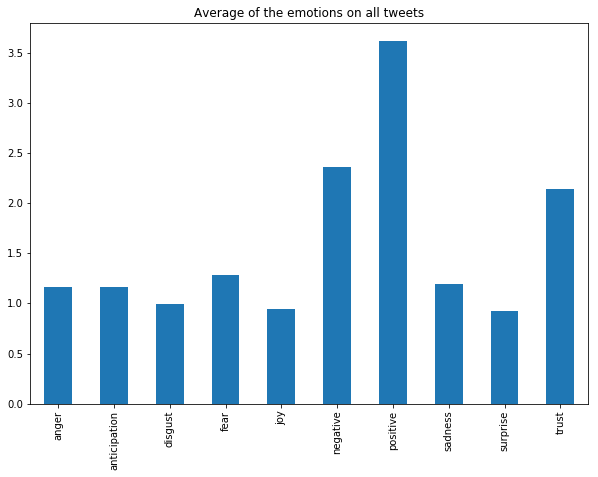

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
mean_all.drop(['favorite_count', 'retweet_count']).plot(kind='bar', title='Average of the emotions on all tweets', ax=ax)
plt.show()

* We can see that our assumption that Trump's tweets are generally more positive holds. As we already stated studying the topics, the trust emotion is generally the most relevant and joy is the lowest with surprise. The other emotions lay on the samae level.

## Word Usage - put stopwords in a json file - add viz

In [37]:
stopwords_wordcount = [
    'the', 'to', 'is', 'a', 'and', 'in', 'you', 'of', 'i', 'for', 'at', 'on',
    'be', 'amp', 'your', 'my', 'it', 'will', 'our', 'us', 'we', 'cont', 'are',
    'from', 'has', 'that', 'this', 'she', 'her', 'have', 'with', 'he',
    'new', 'just', 'from', 'now', 'as', 'he', 'its', 'by', 'they', 'was',
    'not', 'so', 'more', 'about', 'what', 'all', 'get', 'but', 'one',
    'over', 'their', 'why', 'when', 'what', 'them', 'who', 'said', 'out',
    'would', 'had', 'can', 'should', 'would', 'do', 'been', 'an', 'cont', 'dont',
    '1','2','3','4','5','6','7','8','9', 'http', 'https', 'how', 'ing', 'gre'];

strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [38]:
topic_word_count = {}
topics = tweets_topic_em.topic.unique()
for topic in topics:
    topic_dict = {}
    temp = tweets_topic_em[tweets_topic_em.topic == topic]

    for index, row in temp.iterrows():
        text = clean_sentences(row.text.lower()).split()

        text = [word for word in text if word not in stopwords]

        counter = collections.Counter(text)
        for word, count in counter.items():

            if word in topic_dict:
                topic_dict[word] += count
            else:
                topic_dict[word] = count
                
    ordered_dict = dict(sorted(topic_dict.items(), key=operator.itemgetter(1), reverse=True))
    topic_word_count[topic] = ordered_dict

In [40]:
for (key, value) in topic_word_count.items():
    print('TOPIC: ', key.upper())
    print('The 20 most used words are: ')
    i = 20
    for (word, count) in value.items():
        print(word + ': ' + str(count))
        i -= 1
        if i == 0:
            break
    print('\n')

TOPIC:  BUSINESS
The 20 most used words are: 
golf: 109
hotel: 72
macys: 65
national: 54
ties: 54
international: 51
tower: 50
shirts: 38
scotland: 37
doral: 35
chicago: 34
blue: 33
club: 32
monster: 31
success: 30
building: 28
collection: 27
business: 24
signature: 24
links: 23


TOPIC:  CHINA
The 20 most used words are: 
china: 152
barackobama: 33
cont: 27
chinese: 26
oil: 23
currency: 16
jobs: 14
laughing: 14
america: 13
leaders: 12
chinas: 10
government: 9
deal: 9
iran: 9
money: 9
debt: 8
iraq: 7
russia: 7
continue: 7
steal: 6


TOPIC:  FOREIGN_POLITICS
The 20 most used words are: 
china: 152
iran: 72
oil: 71
iraq: 69
barackobama: 65
cont: 57
obama: 48
deal: 37
america: 31
gas: 30
nuclear: 27
chinese: 26
leaders: 25
isis: 25
military: 25
russia: 23
country: 23
foreign: 22
jobs: 20
laughing: 19


TOPIC:  HILLARY
The 20 most used words are: 
hillary: 337
crooked: 180
clinton: 162
bernie: 35
media: 32
people: 26
president: 26
debate: 25
obama: 24
cnn: 23
beat: 23
years: 22
hillaryclint